In [2]:
import numpy as np
import scipy as sc

In [3]:
# Testsystem aufsetzen
import control as con

# pt2 System
K = 1
d = 0.5
T = 10
delay = 0

a0 = 1
a1 = (2 * d * T) #16
a2 = (T**2) #100
b0 = K

# Polynom
tf_1 = con.matlab.tf(K, [a2, a1, a0])
#print tf_1

# Zustandsraum
ss_1a = con.matlab.tf2ss(tf_1)
#print ss_1a

# Füge Zeitversatz zu
d_num, d_den = con.pade(delay, 1)
tf_delay = con.tf(d_num, d_den)
ss_delay = con.series(tf_delay, tf_1)

#print con.matlab.tf2ss(ss_delay)

Populating the interactive namespace from numpy and matplotlib


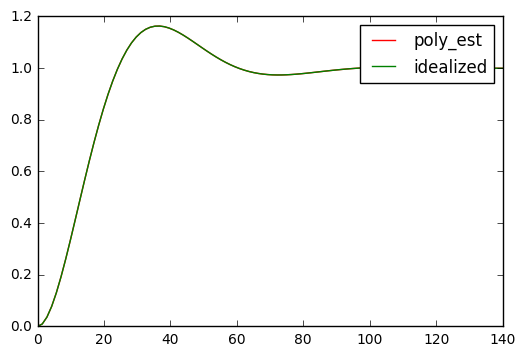

In [4]:
import matplotlib.pyplot as plt
%pylab inline
d_yout, d_T = con.matlab.step(ss_delay)
yout, T = con.matlab.step(tf_1) # step without delay

plt.plot(d_T, d_yout, 'r-', label='poly_est')
plt.plot(np.add(d_T, delay), yout, 'g-', label='idealized') #delay in timeaxis!
plt.legend()

In [5]:
# Sammle Systemteile (sinnlos in diesm Beispiel, aber der Vollständigkeit halber)
# original System Matrizen
A0 = ss_1a.A
b0 = ss_1a.B
C0 = ss_1a.C
d0 = ss_1a.D

# Platzierte pole
a_hat = np.matrix([[-0.2], [-0.2]]) # kA... einfach mal schnellere Pole machen

u_max = 0.1 # kA... Einfach mal begrenzen

In [31]:
# Zustandslose Hilfsfunktionen

### Seite 35; (4.6)
def _D(v, n):
    return np.diag([v**x for x in range(1, n+1)])

### Seite 35; (4.5)
def _k(v, D, a_hat, a, n):
    D_inv = np.linalg.inv(D(v, n))
    #print np.subtract(np.dot(D_inv, a_hat), a) == D_inv.dot(a_hat) - a
    return D_inv.dot(a_hat) - a

### Seite 37; (4.8)
def _R(v, D, R1):
    D_inv = np.linalg.inv(D(v, n))
    return np.dot(np.dot(D_inv, R1), D_inv)

### Seite 35; (4.3)
def _e(v, k, D, a_hat, a, R, R1, u_max, n):
    return 1.0/u_max**2 * np.dot(np.dot(_k(v, D, a_hat, a, n).transpose(), np.linalg.inv(R(v, D, R1))), _k(v, D, a_hat, a, n))

### Seite 40; (4.23)
# 1.te Ableitung e nach v
def _d_e(v, k, D, a_hat, a, R, R1, u_max, n, N):
    D = D(v, n)
    R1_inv = np.linalg.inv(R1)
    return -2.0/(u_max**2 * v) * (a.transpose().dot(D).dot(R1_inv).dot(N).dot(D).dot(a) - a_hat.transpose().dot(R1_inv).dot(N).dot(D).dot(a))



#############################################
# R1 muss symmetrisch sein!
def _R1_from_arr(r1, n):
    if len(r1) != ((n+1)*n)//2:
        raise ValueError("r1 has not right length! Has {} -> Needs {}".format(len(r1), ((n+1)*n)//2))

    R1 = np.zeros([n, n])
    r1_pos = 0
    for i in xrange(0, n):
        for j in xrange(i, n):
            R1[i,j] = r1[r1_pos]
            if i != j:
                R1[j,i] = r1[r1_pos]
            #print i, j, r1_pos
            #print r1[r1_pos]
            #print R1
            r1_pos += 1
    return R1

def initializeR1(n):
    return np.diag(np.random.rand(n)) # Immer positiv semidefinit für random  im Bereich von [0,1)

#############################################

### Seite 54; (4.58)
def Q(R1):
    return np.linalg.inv(R1)

### Seite 54; (4.58)
def z(R1, a_hat):
    return np.linalg.inv(R1).dot(a_hat)

### Seite 37 (im Text zwischen (4.12) und (4.13))
def N(n):
    return np.diag([p for p in xrange(-n, 0, 1)])

### Seite 55; (4.64)
def M(n):
    return np.diag([p for p in xrange(0, n, 1)])

### Seite 55; (4.64)
def P(l, k, n):
    I = np.eye(n)
    Mn = M(n)
    P = I
    if k == 0:
        pass
    else:
        for q in xrange(0, k, 1):
            P = P * ((l-q)*I + Mn)
    return P

### Seite 50 (oben)
def _H(k, n):
    H = np.zeros((n, n))
    H[k, k] = 1
    return H

############### TO BE TESTED!!!! ########################
############### TO BE TESTED!!!! ########################
############### TO BE TESTED!!!! ########################
############### TO BE TESTED!!!! ########################

### Seite 55 (mitte)
### Helper für a_theta! -> Summand für erste Bedinung (i<=(m-1)/2)
def _a_theta_1(i, k, a, _H, n, Q, N, z):
    return a.transpose().dot(_H(n+k-i, n)).dot(Q).dot(N).dot(_H(n-k+1, n)).dot(a) - (-z.transpose().dot(N).dot(_H(n-i, n)).dot(a))

### Helper für a_theta! -> Summand für erste Bedinung (i<=(m-1)/2)
def _a_theta_2(i, k, a, _H, n, Q, N, z):
    return a.transpose().dot(_H(k, n)).dot(Q).dot(N).dot(_H(2*n-i-k+1)).dot(a)

### Seite 55 (mitte) -> Bezeichung a_i !!!
def a_theta(i, m, a, _H, n, Q, N, z):
    ai = 0
    if i <= ((m-1)/2):
        ai = np.sum(
            [_a_theta_1(i, k, a, _H, n, Q, N, z) for k in xrange(1, i+1, 1)]
        )
    elif i > (m+1):
        ai = np.sum(
            [_a_theta_2(i, k, a, _H, n, Q, N, z) for k in xrange(1, 2*n-i, 1)]
        )
    else:
        # Bereits auf 0
        pass
    return ai

### Seite 55 (unten)
# Definition von eps -> Seite 48 (4.46) -> Bereichverschobenes v [-1,1] -> eps [0,1]
def eps(v):
    raise()

# Helper in er Summe von a_theta_tilde
from scipy.special import comb as nchoosek # n Choose k (n ueber k)
def _a_theta_tilde_1((i, j, a_theta, eps)):
    return nchoosek(i, i-j) * ((1+eps)/(1-eps))**(i-j) * ((1-eps)/2)**i * a_theta

def a_theta_tilde(j, m, a_theta, eps):
    return np.sum(
        [_a_theta_tilde_1(i, j, a_theta, eps) for i in xrange(j, m+1, 1)]
    )

#### m == n ????????????????? ####
#### m == n ????????????????? ####
#### m == n ????????????????? ####
#### m == n ????????????????? ####
#### m == n ????????????????? ####
### Seite 50 (oben)
def Theta_Sigma():
    pass

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [6]:
## Hilfsfunktionen nur abhängig von Laufzeitvariablen
## Umwandlung des Systems in gewünschte Form

## Im scope definiter Variablen:
#
# A0, b0, C0, d0 -> Systemmatrizen
# a_hat -> gewünschte pole
# u_max -> +/- limit von u

# Transformation in Regelungsnormalform
ss, T = con.canonical_form(con.ss(A0, b0, C0, d0), form='reachable')

n = len(b0)
N = np.diag([p for p in xrange(-n, 0, 1)])

A = ss.A
a = (np.matrix(ss.A[0][:])).transpose()
b = np.matrix(ss.B).transpose()
C = np.matrix(ss.C)
d = np.matrix(ss.D) # == 0!

# D(v)
D = lambda v: _D(v, n)

# k(v)
k = lambda v: _k(v, _D, a_hat, a, n)

# R(v, R1)
R = lambda v, R1: _R(v, _D, R1)

# e(v, R1)
e = lambda v, R1: _e(v, k, _D, a_hat, a, _R, R1, u_max, n)

# g(v, x, R1)
g = lambda v, x, R1: e(v, R1) * x.transpose().dot(R1).dot(x) - 1.0

# d_e(v, R1)
d_e = lambda v, R1: _d_e(v, k, _D, a_hat, a, _R, R1, u_max, n, N)

In [7]:
# Bedingungen

# Test auf positiv semi-definiteit (alle Eigenwerte >= 0)
def isPSD2(A, tol=1e-8):
    E,V = np.linalg.eigh(A)
    return np.all(E > -tol)

# Etwas schneller, ist positiv semi definit
def isPSD(A, tol=1e-8):
    w = np.linalg.eigvalsh(A)
    return np.all(w > -tol), w

def isNSD_sum(A, B, tol=1e-8):
    T = A.transpose().dot(B) + B.dot(A)
    w = np.linalg.eigvalsh(T)
    return np.all(w < tol), w

In [8]:
#A = np.random.rand(3,3)
#%timeit isPSD(A)
#%timeit isPSD2(A)
print isPSD(initializeR1(3))

(True, array([ 0.00039002,  0.08764471,  0.15915631]))


In [9]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pretty = lambda x: pp.pprint(x)

print "A:"
pretty(A)
print "a:"
pretty(a)
print "b:"
pretty(b)
print "C:"
pretty(C)
print "d:"
pretty(d)

print "a_hat:"
pretty(a_hat)
print "n:", n
print "N:"
pretty(N)

A:
array([[-0.1 , -0.01],
       [ 1.  ,  0.  ]])
a:
matrix([[-0.1 ],
        [-0.01]])
b:
matrix([[ 1.,  0.]])
C:
matrix([[ 0.  ,  0.01]])
d:
matrix([[ 0.]])
a_hat:
matrix([[-0.2],
        [-0.2]])
n: 2
N:
array([[-2,  0],
       [ 0, -1]])


In [10]:
D1 = D(1)

k1 = k(1)
#print k_1 == k1

# Gebiet des Zustandsbereiches für x (hier Rechteckig)
X1 = [np.matrix([0, 0]).transpose(),
      np.matrix([0, 1]).transpose(),
      np.matrix([1, 1]).transpose(),
      np.matrix([1, 0]).transpose()]

A1_hat = A - b.dot(k(1))
#print A1_hat

#http://deap.readthedocs.io/en/master/tutorials/advanced/constraints.html

In [11]:
def eval_Psd_R1(individual):
    R1 = _R1_from_arr(individual, n)
    psd, w = isPSD(R1)
    pain = 0
    if not psd:
        pain = np.sum(np.abs([wp for wp in w if wp < 0]))
    return pain

def eval_Volume(individual):
    R1 = _R1_from_arr(individual, n)
    ##################################
    # TODO: Ist "hoch n" korrekt???  #
    ##################################
    return (1.0/(e(1, R1)**n * np.linalg.det(R1))).flat[0]

def eval_Einschluss(individual):
    R1 = _R1_from_arr(individual, n)
    nsd, w = isNSD_sum(A1_hat, R1)
    pain = 0
    if not nsd:
        pain = np.sum(np.abs([wp for wp in w if wp > 0]))
    return pain

def eval_Schachtelung(individual):
    R1 = _R1_from_arr(individual, n)
    nsd, w = isNSD_sum(N, R1)
    pain = 0
    if not nsd:
        pain = np.sum(np.abs([wp for wp in w if wp > 0]))
    return pain

from scipy.optimize import minimize_scalar

def eval_Monotonie(individual):
    R1 = _R1_from_arr(individual, n)
    f = lambda v: -d_e(v, R1)
    res = minimize_scalar(f, bounds=(0, 1), method='bounded')
    pain = 0
    if res.fun.flat[0] > 0:
        pain = res.fun.flat[0]
    return pain

def eval_region(individual):
    R1 = _R1_from_arr(individual, n)
    G1 = [g(1, x, R1) for x in X1]
    pain = 0
    if not np.max(G1) < 0:
        pain = np.max(G1)
    return pain


In [12]:
# Creates and starts the algorithm
#pop = toolbox.population(n=100)
#halloffame = tools.HallOfFame(maxsize=100)

#winpop, logbook = algorithms.eaMuPlusLambda(pop, 
#                              toolbox, 
#                              mu = 5, 
#                              lambda_ = 100, 
#                              cxpb = 0.5, 
#                              mutpb = 0.5, 
#                              ngen = 120,
#                              #[, stats, halloffame, verbose]
#                              halloffame = halloffame,
#                              verbose = True
#                             )

#ind = toolbox.individual()
#R1 = _R1_from_arr(ind, n)

#print eval_Monotonie(ind)

#v_arr = np.arange(0.0001, 1, 0.0001)
#de_max = np.max([d_e(v, R1) for v in v_arr]) 
#print de_max

#f = lambda v: -d_e(v, R1)
#res = minimize_scalar(f, bounds=(0, 1), method='bounded')
#print res.fun.flat[0]
#print f(res.x)
#pain = 0
#if not res.x <= 0:
#    pain = f(res.x)
#return pain

In [13]:
def eval_WSVR(individual):
    #print "Entering"
    pain = [0, 0, 0, 0, 0, 0, 0]
    R1 = _R1_from_arr(individual, n)
    try:
        pain[0] = eval_Volume(individual).flat[0]

        psd, w = isPSD(R1)
        if not psd:
            pain[1] = np.sum(np.abs([wp for wp in w if wp < 0]))

        nsd, w = isNSD_sum(A1_hat, R1)
        if not nsd:
            pain[2] = np.sum(np.abs([wp for wp in w if wp > 0]))

        nsd, w = isNSD_sum(N, R1)
        if not nsd:
            pain[3] = np.sum(np.abs([wp for wp in w if wp > 0]))

        de_max = eval_Monotonie(individual)
        pain[4] = de_max

        G1 = [g(1, x, R1) for x in X1]
        if np.max(G1) >= 0:
#            pain[5] = np.sum([g for g in G1 if g >= 0])
            pain[5] = np.max(G1)
    except ValueError as e:
        #print "Inappropriate value", 
        pain[6] = numpy.float64(10000)
    except:
        #print "Unexpected error:", sys.exc_info()[0]
        pain[6] = numpy.float64(10000)
    finally:
        #print np.sum(pain), "\n", pain, "\n->", individual
        #return [np.sum(pain)]
        return pain

# Initialize deap population
import random
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(0,        # Volumenmaximierung        -> Volumen
                                                    -1.0,      # R1 > 0                    -> sum(eigenvalues < 0)
                                                    -1.0,      # AR+RA < 0                 -> sum(eigenvalues > 0)
                                                    -1.0,      # NR+RN < 0                 -> sum(eigenvalues > 0)
                                                    -1.0e-8,   # max(e'(v)) <= 0           -> max(e'(v))
                                                    -1.0,      # G(1) for all x in X0      -> sum(g(1, x) >= 0)
                                                    -10.0,))   # Some other exception      -> 10000
creator.create("Individual", list, fitness=creator.FitnessMin)


toolbox = base.Toolbox()
toolbox.register("attr_float", random.random) # float value between [0,1)
toolbox.register("attr_zero", lambda: 0)
#toolbox.register("individual", tools.initRepeat,
#                               creator.Individual,
#                               toolbox.attr_float,
#                               n=3)

#TODO: Initializer for all sizes (randon on diag)
toolbox.register("individual", tools.initCycle,
                               creator.Individual,
                               (toolbox.attr_float, toolbox.attr_zero, toolbox.attr_float),
                               n=1)

print toolbox.individual()
toolbox.register("population", tools.initRepeat,
                               list, 
                               toolbox.individual)

toolbox.register("evaluate", eval_WSVR)

toolbox.register("mutate", tools.mutGaussian, mu=0.0,
                                              sigma=100.0,
                                              indpb=0.6)
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("select", tools.selTournament, tournsize=5)

[0.8466176109494559, 0, 0.8592974404169016]


In [14]:
import time
#fig, ax = plt.subplots(1,1)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_xlim(0,100)
#ax.set_ylim(-0.5,10000.5)

def plt_lines(ax, x, y, colors=['b-']):
    if ax.lines:
        for i, line in enumerate(ax.lines):
            line.set_xdata(x)
            y0 = y[i]
            line.set_ydata(y0)
    else:
        for i, y0 in enumerate(y):
            if i >= len(colors):
                color = 'b'
            else:
                color = colors[i]
            ax.plot(x, y0, color)
    fig.canvas.draw()

def plot_logs(ax, logbook):

    x = logbook.select("gen")
    y = [logbook.select("min"),
         logbook.select("avg"),
         logbook.select("max")]
    if len(x) < 100:
        x = x[-100:]
        y = y[-100:]
    colors = ['b-', 'y-', 'r']
    plt_lines(ax, x, y, colors)

    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness")
    
#plot_logs(ax, logbook)

In [16]:
%matplotlib notebook

import time
from datetime import datetime

#fig, ax = plt.subplots(1,1)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_xlim(0,100)
#ax.set_ylim(-0.5,10000.5)

import pickle
import json

from IPython.display import clear_output
import matplotlib.pyplot as plt

FREQ = 10000
NGEN = 1000000# Number of iterations -> Ca. 1 Tag
CXPB = 0.3
MUTPB = 0.5

def evo(checkpoint=None):
    try:
        # A file name has been given, then load the data from the file
        print "start loading"
        cp = pickle.load(open(checkpoint, "r"))
        population = cp["population"]
        start_gen = cp["generation"]
        halloffame = cp["halloffame"]
        logbook = tools.Logbook()
        random.setstate(cp["rndstate"])
        print "loading done"
    except:
        print "loading failed"
        # Start a new evolution
        population = toolbox.population(n=200)
        start_gen = 0
        halloffame = tools.HallOfFame(maxsize=30)
        logbook = tools.Logbook()
    finally:
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("max", numpy.max)
        stats.register("min", numpy.min)
        print "start evo@{}".format(start_gen)
        for gen in xrange(start_gen, NGEN+start_gen):
            t = time.time()
            population = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            halloffame.update(population)
            record = stats.compile(population)
            logbook.record(gen=gen, evals=len(invalid_ind), **record)

            population = toolbox.select(population, k=25)

            if gen % FREQ == 0:
                clear_output()
                #fig, ax = plt.subplots(1,1)
                #ax.set_xlabel('X')
                #ax.set_ylabel('Y')
                #ax.set_xlim(0,100)
                #ax.set_ylim(-0.5,10000.5)
                elapsed = (time.time() - t)/FREQ
                print 'Elapsed (Average over last {} generations): {}s per Generation'.format(FREQ , (time.time() - t))
                
                best = tools.selBest(population, k=1)[0]
                score = eval_WSVR(best)
                print "Gen:", gen, "\nScore:", score, "\nIndividuum:", best
                #plot_logs(ax, logbook)

            if gen % FREQ == 0:
                # Fill the dictionary using the dict(key=value[, ...]) constructor
                cp = dict(population=population, generation=gen, halloffame=halloffame,
                          rndstate=random.getstate())
                try:
                    pickle.dump(cp, open("checkpoint_name.pkl", "wb"))
                    with open("logbook.txt", "a") as f:
                        json.dump(logbook, f)
                    logbook = tools.Logbook()
                    print "Pickled values!"
                except:
                    time.sleep(5)
                    pickle.dump(cp, open(datetime.now().strftime('%Y-%m-%d_%H_%M_%S')+"checkpoint_name.pkl.bck", "wb"))
                    print "Pickle failed!"
        # Fill the dictionary using the dict(key=value[, ...]) constructor
        cp = dict(population=population, generation=gen, halloffame=halloffame, rndstate=random.getstate())
        pickle.dump(cp, open(datetime.now().strftime('%Y-%m-%d_%H_%M_%S')+"checkpoint_name.pkl", "wb"))
        with open("logbook.txt", "a") as f:
            json.dump(logbook, f)
        print "Pickled values!"
        return population, logbook, stats, halloffame

#winpop, logbook, stats, halloffame = evo()
winpop, logbook, stats, halloffame = evo("checkpoint_name.pkl")

Elapsed (Average over last 10000 generations): 0.0520000457764s per Generation
Gen: 3570000 
Score: [7.9907915132282768e-10, 0, 1.7304077628566006e-05, 4.3740821504372462, 475788.39325797581, 272137380.99625236, 0] 
Individuum: [302.66237200869034, -73.97845421903205, 18.082238635227277]
Pickled values!
Pickled values!


In [32]:
import json
logbook2 = logbook[0:10]
with open("logbook2.txt", "a") as f:
    json.dump(logbook2, f)
logbook2 = tools.Logbook()
with open("logbook2.txt", "a") as f:
    json.dump(logbook2, f)

In [ ]:
best = tools.selBest(winpop, k=1)
score = eval_WSVR(best[0])
print "***********************"
print best[0]
print score
print "***********************"
print "-----Hall of fame -----"
print halloffame

In [ ]:
Elapsed (Average over last 500 generations): 0.095999956131s per Generation
Gen: 1270500 
Score: [14005.001650128019, 0, 312.13315396729263, 13.6404395282309, 27.925672480336861, 13.128509674875632, 0] 
Individuum: [43.51123114851988, 82.85168554131135, 157.762715251176]
Pickled values!

In [ ]:
Elapsed (Average over last 500 generations): 0.139999866486s per Generation
Gen: 4500 
Score: [75.018287562993905, 6492.5223624943601, 2685.378181199048, 16231.535019218469, 0, 7.4100209311506475, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5082.691800852317]
Pickled values!
Gen: 4501 
Score: [75.018287562993905, 6492.5223624943601, 2685.378181199048, 16231.535019218469, 0, 7.4100209311506475, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5082.691800852317]
Gen: 4502 
Score: [75.018287562993905, 6492.5223624943601, 2685.378181199048, 16231.535019218469, 0, 7.4100209311506475, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5082.691800852317]
Gen: 4503 
Score: [75.018287562993905, 6492.5223624943601, 2685.378181199048, 16231.535019218469, 0, 7.4100209311506475, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5082.691800852317]
Gen: 4504 
Score: [524.51271308897958, 6525.2224038544482, 2730.5150409724483, 16270.006986303451, 0, 19.490434021188562, 0] 
Individuum: [-1390.536807903745, -2671.9523973932687, -5134.685595950703]
Gen: 4505 
Score: [386.61343004909742, 6477.3755872590264, 2671.770935446747, 16212.285641842151, 0, 7.459997355651705, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5067.545025616984]
Gen: 4506 
Score: [386.61343004909742, 6477.3755872590264, 2671.770935446747, 16212.285641842151, 0, 7.459997355651705, 0] 
Individuum: [-1409.8305616420432, -2671.9523973932687, -5067.545025616984]
Gen: 4507 
Score: [72.54091118130242, 6477.3755872590282, 2674.8694447941243, 16200.324141240964, 0, 7.4154463588108879, 0] 
Individuum: [-1409.8305616420432, -2667.8111859766213, -5067.545025616984]
Gen: 4508 
Score: [47.580818238598383, 6548.0582701454241, 2689.2995104538322, 16396.962849619089, 0, 7.4805805429372754, 0] 
Individuum: [-1437.8285126629762, -2702.938427924901, -5110.229757482448]
Gen: 4509 
Score: [345.70837090534332, 6549.4236029213516, 2666.8850655428414, 16450.33862258153, 0, 12.455793172928853, 0] 
Individuum: [-1451.4689895405147, -2719.7843090757538, -5097.954613380837]
Gen: 4510 
Score: [36.678634563563932, 6569.0676168031614, 2677.8110904134701, 16479.424094379166, 0, 7.6405802872273423, 0] 
Individuum: [-1458.8378593207142, -2720.720365015236, -5110.229757482448]
Gen: 4511 
Score: [287.9079014642183, 6578.9164562966871, 2753.7197870259461, 16401.377047350441, 0, 9.0421726658126396, 0] 
Individuum: [-1401.8761480550852, -2693.0723135305766, -5177.040308241602]
Gen: 4512 
Score: [90.004821954371891, 6583.8979213919583, 2663.8231865173748, 16560.896209665501, 0, 8.9004586853590713, 0] 
Individuum: [-1473.6681639095107, -2741.21861011233, -5110.229757482448]
Gen: 4513 
Score: [120.46287926058706, 6511.7221979940568, 2670.0847424337235, 16320.935770081491, 0, 7.640604123244314, 0] 
Individuum: [-1430.4150441543525, -2693.0723135305766, -5081.307153839704]
Gen: 4514 
Score: [57.234254204526287, 6524.8491823296836, 2681.8651972802395, 16337.551111620156, 0, 7.4743238461116306, 0] 
Individuum: [-1430.4150441543525, -2693.0723135305766, -5094.434138175332]
Gen: 4515 
Score: [44.362379332395136, 6424.0015088192185, 2560.3693244094975, 16220.164267994516, 0, 10.007055388617761, 0] 
Individuum: [-1468.9117143359026, -2693.0723135305766, -4955.089794483316]
Gen: 4516 
Score: [286.55695095427706, 6419.2082058524957, 2635.7500980842547, 16085.997689752425, 0, 7.7793375878318844, 0] 
Individuum: [-1406.3976884452015, -2654.0117641017055, -5012.810517407294]
Gen: 4517 
Score: [286.55695095427706, 6419.2082058524957, 2635.7500980842547, 16085.997689752425, 0, 7.7793375878318844, 0] 
Individuum: [-1406.3976884452015, -2654.0117641017055, -5012.810517407294]
Gen: 4518 
Score: [286.55695095427706, 6419.2082058524957, 2635.7500980842547, 16085.997689752425, 0, 7.7793375878318844, 0] 
Individuum: [-1406.3976884452015, -2654.0117641017055, -5012.810517407294]
Gen: 4519 
Score: [44.362379332395136, 6424.0015088192185, 2560.3693244094975, 16220.164267994516, 0, 10.007055388617761, 0] 
Individuum: [-1468.9117143359026, -2693.0723135305766, -4955.089794483316]
Gen: 4520 
Score: [44.362379332395136, 6424.0015088192185, 2560.3693244094975, 16220.164267994516, 0, 10.007055388617761, 0] 
Individuum: [-1468.9117143359026, -2693.0723135305766, -4955.089794483316]
Gen: 4521 
Score: [17.310017180900161, 6316.918377417479, 2475.0545163872671, 16006.975893820989, 0, 9.4242120750610301, 0] 
Individuum: [-1482.9200641512025, -2663.896272507516, -4833.998313266277]
Gen: 4522 
Score: [82.301186597568829, 6506.6147791861367, 2636.2937564905037, 16359.401205665205, 0, 8.5227872384520325, 0] 
Individuum: [-1453.8092099093615, -2706.8019337763208, -5052.805569276775]
Gen: 4523 
Score: [82.301186597568829, 6506.6147791861367, 2636.2937564905037, 16359.401205665205, 0, 8.5227872384520325, 0] 
Individuum: [-1453.8092099093615, -2706.8019337763208, -5052.805569276775]
Gen: 4524 
Score: [82.301186597568829, 6506.6147791861367, 2636.2937564905037, 16359.401205665205, 0, 8.5227872384520325, 0] 
Individuum: [-1453.8092099093615, -2706.8019337763208, -5052.805569276775]
Gen: 4525 
Score: [19.280980300107249, 6456.6471650334788, 2576.0664591024492, 16279.766107594827, 0, 8.2363124289345553, 0] 
Individuum: [-1480.5725910496897, -2698.5209770629867, -4976.074573983789]
Gen: 4526 
Score: [72.989846978233643, 6585.3672261007869, 2649.8577960828475, 16588.354159580544, 0, 9.556633406664556, 0] 
Individuum: [-1485.3474048217308, -2749.0636412943873, -5100.0198212790565]
Gen: 4527 
Score: [54.705983071120542, 6560.2292249986931, 2633.4236160030719, 16533.249421337041, 0, 9.2139351035838306, 0] 
Individuum: [-1485.3474048217308, -2740.9038744455074, -5074.881820176963]
Gen: 4528 
Score: [54.705983071120542, 6560.2292249986931, 2633.4236160030719, 16533.249421337041, 0, 9.2139351035838306, 0] 
Individuum: [-1485.3474048217308, -2740.9038744455074, -5074.881820176963]
Gen: 4529 
Score: [63.949164982916422, 6576.2032436616155, 2638.2924632319769, 16577.966702292084, 0, 9.8568228598939509, 0] 
Individuum: [-1489.5132675481093, -2749.0636412943873, -5086.6899761135055]
Gen: 4530 
Score: [107.59766766145015, 6400.4101894567521, 2635.5184561384394, 16022.988230775125, 0, 7.4617713813553781, 0] 
Individuum: [-1397.8471189148438, -2641.042064984203, -5002.563070541908]
Gen: 4531 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4532 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4533 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4534 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4535 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4536 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4537 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4538 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4539 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4540 
Score: [780.14778521005758, 6333.0049146436486, 2634.0642325114368, 15816.259824472412, 0, 8.3513675155475635, 0] 
Individuum: [-1361.6801399250862, -2601.4233790358153, -4971.324774718562]
Gen: 4541 
Score: [780.14778521005758, 6333.0049146436486, 2634.0642325114368, 15816.259824472412, 0, 8.3513675155475635, 0] 
Individuum: [-1361.6801399250862, -2601.4233790358153, -4971.324774718562]

Gen: 4542 
Score: [262.30703180525666, 6292.9274885367058, 2558.3902880611695, 15812.403723467709, 0, 11.379619085569422, 0] 
Individuum: [-1397.8471189148438, -2615.1999576781914, -4895.080369621862]
Gen: 4543 
Score: [127.33558700968661, 6230.8172325559426, 2598.5717135695595, 15545.911136228613, 0, 7.6616427380031524, 0] 
Individuum: [-1335.7368629340808, -2554.4234460906546, -4895.080369621862]
Gen: 4544 
Score: [127.33558700968661, 6230.8172325559426, 2598.5717135695595, 15545.911136228613, 0, 7.6616427380031524, 0] 
Individuum: [-1335.7368629340808, -2554.4234460906546, -4895.080369621862]
Gen: 4545 
Score: [127.33558700968661, 6230.8172325559426, 2598.5717135695595, 15545.911136228613, 0, 7.6616427380031524, 0] 
Individuum: [-1335.7368629340808, -2554.4234460906546, -4895.080369621862]
Gen: 4546 
Score: [127.33558700968661, 6230.8172325559426, 2598.5717135695595, 15545.911136228613, 0, 7.6616427380031524, 0] 
Individuum: [-1335.7368629340808, -2554.4234460906546, -4895.080369621862]
Gen: 4547 
Score: [893.5028139383852, 6228.2329069157076, 2598.3530773239718, 15542.184376220906, 0, 12.329025257896951, 0] 
Individuum: [-1333.1525372938465, -2554.4234460906546, -4895.080369621862]
Gen: 4548 
Score: [56.081474822288314, 6244.1474905487676, 2610.5707875229232, 15562.966401153048, 0, 7.5736438440782337, 0] 
Individuum: [-1335.7368629340808, -2554.4234460906546, -4908.410627614687]
Gen: 4549 
Score: [21.327332292449931, 6019.8537314249079, 2351.5375291538649, 15274.408398005911, 0, 10.883780339376971, 0] 
Individuum: [-1416.024013529498, -2545.221065248119, -4603.82971789541]
Gen: 4550 
Score: [21.327332292449931, 6019.8537314249079, 2351.5375291538649, 15274.408398005911, 0, 10.883780339376971, 0] 
Individuum: [-1416.024013529498, -2545.221065248119, -4603.82971789541]
Gen: 4551 
Score: [21.327332292449931, 6019.8537314249079, 2351.5375291538649, 15274.408398005911, 0, 10.883780339376971, 0] 
Individuum: [-1416.024013529498, -2545.221065248119, -4603.82971789541]
Gen: 4552 
Score: [39.522644064977136, 6016.5633968914926, 2476.2288616204369, 15054.973594180223, 0, 7.4431770449852053, 0] 
Individuum: [-1318.031950804715, -2479.9298354044245, -4698.5314460867785]
Gen: 4553 
Score: [16.766869004152532, 6401.0191427647378, 2701.5805560328604, 15888.455427989658, 0, 7.5505001942097856, 0] 
Individuum: [-1358.67127376012, -2596.390033760201, -5042.347869004618]
Gen: 4554 
Score: [16.766869004152532, 6401.0191427647378, 2701.5805560328604, 15888.455427989658, 0, 7.5505001942097856, 0] 
Individuum: [-1358.67127376012, -2596.390033760201, -5042.347869004618]
Gen: 4555 
Score: [20.613537854470387, 5999.6372071716341, 2446.6494120794073, 15037.336919038968, 0, 7.5508247334273673, 0] 
Individuum: [-1335.7368629340808, -2479.9298354044245, -4663.900344237553]
Gen: 4556 
Score: [17.349590703962612, 6034.2683090208593, 2473.4144616119606, 15097.694180810764, 0, 7.4701333583127383, 0] 
Individuum: [-1335.7368629340808, -2485.69718403539, -4698.5314460867785]
Gen: 4557 
Score: [96.560792383717967, 5947.9873195526197, 2400.3895173169112, 14972.487556097783, 0, 9.7306765677999483, 0] 
Individuum: [-1335.7368629340808, -2479.9298354044245, -4612.25045661854]
Gen: 4558 
Score: [96.560792383717967, 5947.9873195526197, 2400.3895173169112, 14972.487556097783, 0, 9.7306765677999483, 0] 
Individuum: [-1335.7368629340808, -2479.9298354044245, -4612.25045661854]
Gen: 4559 
Score: [96.560792383717967, 5947.9873195526197, 2400.3895173169112, 14972.487556097783, 0, 9.7306765677999483, 0] 
Individuum: [-1335.7368629340808, -2479.9298354044245, -4612.25045661854]
Gen: 4560 
Score: [96.560792383717967, 5947.9873195526197, 2400.3895173169112, 14972.487556097783, 0, 9.7306765677999483, 0] 
Individuum: [-1335.7368629340808, -2479.9298354044245, -4612.25045661854]
Gen: 4561 
Score: [143.48985934406201, 5946.8235595368151, 2399.8361806128296, 14972.530689046715, 0, 18.042679261496563, 0] 
Individuum: [-1334.5731029182748, -2480.544037226701, -4612.25045661854]
Gen: 4562 
Score: [46.840194480514086, 5968.8745525475088, 2504.9811271010221, 14859.861263362318, 0, 7.6646293769047897, 0] 
Individuum: [-1270.3431064607314, -2436.2519686848764, -4698.5314460867785]
Gen: 4563 
Score: [86.12191452587119, 5971.2650921439081, 2522.1646769391668, 14846.273353383118, 0, 8.7578107529341356, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4714.590382437531]
Gen: 4564 
Score: [86.12191452587119, 5971.2650921439081, 2522.1646769391668, 14846.273353383118, 0, 8.7578107529341356, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4714.590382437531]
Gen: 4565 
Score: [101.61848122826449, 5882.593563079271, 2441.5773863683639, 14694.883074744741, 0, 7.4434780429071949, 0] 
Individuum: [-1270.3431064607314, -2417.289050045214, -4612.25045661854]
Gen: 4566 
Score: [86.12191452587119, 5971.2650921439081, 2522.1646769391668, 14846.273353383118, 0, 8.7578107529341356, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4714.590382437531]
Gen: 4567 
Score: [82.269520024007988, 5971.959765449953, 2522.7912397332184, 14847.168774590591, 0, 8.6930681858251955, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4715.285055743578]
Gen: 4568 
Score: [82.269520024007988, 5971.959765449953, 2522.7912397332184, 14847.168774590591, 0, 8.6930681858251955, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4715.285055743578]
Gen: 4569 
Score: [82.269520024007988, 5971.959765449953, 2522.7912397332184, 14847.168774590591, 0, 8.6930681858251955, 0] 
Individuum: [-1256.6747097063758, -2431.130151575889, -4715.285055743578]
Gen: 4570 
Score: [69.096680279240843, 5935.3294396739884, 2504.1972744797627, 14759.55698378287, 0, 8.2691842174722385, 0] 
Individuum: [-1251.794860447897, -2417.289050045214, -4683.5345792260905]
Gen: 4571 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4572 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4573 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4574 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4575 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4576 
Score: [218.80192912242316, 6075.4981074299503, 2463.0191241668508, 15277.816215390219, 0, 14.275712628543355, 0] 
Individuum: [-1354.8134026116252, -2528.481674948324, -4720.684704818325]
Gen: 4577 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4578 
Score: [299.19117847967749, 6042.5101116843935, 2483.3070678639833, 15138.410062512896, 0, 7.6950815177619294, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4720.347908630379]
Gen: 4579 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4580 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4581 
Score: [157.73857213171743, 6046.4764577055266, 2486.8672140972258, 15143.436584705394, 0, 7.5266686331520827, 0] 
Individuum: [-1322.1622030540152, -2497.1344685937033, -4724.314254651511]
Gen: 4582 
Score: [53.83972990558285, 6229.7886608738008, 2514.8570603205744, 15675.615130275406, 0, 8.4243159679146302, 0] 
Individuum: [-1400.1554322046468, -2595.1808581956234, -4829.633228669154]
Gen: 4583 
Score: [53.827424423877829, 6051.2954337863284, 2546.6928539452738, 15055.513276142146, 0, 7.860876281823078, 0] 
Individuum: [-1281.9453603830877, -2466.8793000626656, -4769.35007340324]

Gen: 4584 
Score: [53.827424423877829, 6051.2954337863284, 2546.6928539452738, 15055.513276142146, 0, 7.860876281823078, 0] 
Individuum: [-1281.9453603830877, -2466.8793000626656, -4769.35007340324]
Gen: 4585 
Score: [178.72158845051499, 6254.4379767702121, 2588.0201283051001, 15639.091606196564, 0, 7.4126599624057974, 0] 
Individuum: [-1355.7351416265483, -2575.0845907935995, -4898.702835143664]
Gen: 4586 
Score: [178.72158845051499, 6254.4379767702121, 2588.0201283051001, 15639.091606196564, 0, 7.4126599624057974, 0] 
Individuum: [-1355.7351416265483, -2575.0845907935995, -4898.702835143664]
Gen: 4587 
Score: [76.334504830358696, 6372.3410590044514, 2664.2621064480327, 15885.206002762783, 0, 7.6500350005986206, 0] 
Individuum: [-1362.1151943650816, -2607.871549353712, -5010.22586463937]
Gen: 4588 
Score: [2268.774932692791, 6308.3261624937404, 2592.1458621390102, 15806.861412596243, 0, 20.286887033866421, 0] 
Individuum: [-1380.0093266472254, -2607.871549353712, -4928.3168358465155]
Gen: 4589 
Score: [94.305776539693326, 6312.2297857135063, 2592.4754906144781, 15812.586984534664, 0, 7.5299665355911696, 0] 
Individuum: [-1383.9129498669913, -2607.871549353712, -4928.3168358465155]
Gen: 4590 
Score: [48.218923441365014, 6385.3045424655511, 2545.7084891663062, 16128.424295808818, 0, 33.159328866933173, 0] 
Individuum: [-1456.987706619037, -2679.1875412129043, -4928.3168358465155]
Gen: 4591 
Score: [48.218923441365014, 6385.3045424655511, 2545.7084891663062, 16128.424295808818, 0, 33.159328866933173, 0] 
Individuum: [-1456.987706619037, -2679.1875412129043, -4928.3168358465155]
Gen: 4592 
Score: [48.218923441365014, 6385.3045424655511, 2545.7084891663062, 16128.424295808818, 0, 33.159328866933173, 0] 
Individuum: [-1456.987706619037, -2679.1875412129043, -4928.3168358465155]
Gen: 4593 
Score: [48.218923441365014, 6385.3045424655511, 2545.7084891663062, 16128.424295808818, 0, 33.159328866933173, 0] 
Individuum: [-1456.987706619037, -2679.1875412129043, -4928.3168358465155]
Gen: 4594 
Score: [24.203359521436056, 6254.6192326747969, 2461.4904858221817, 15838.723468844266, 0, 9.9899576762960756, 0] 
Individuum: [-1456.987706619037, -2635.2706530520504, -4797.631526055759]
Gen: 4595 
Score: [65.95398406497992, 6098.6187791550728, 2435.6686733456336, 15394.432911876687, 0, 12.418749730207505, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4709.417989806288]
Gen: 4596 
Score: [65.95398406497992, 6098.6187791550728, 2435.6686733456336, 15394.432911876687, 0, 12.418749730207505, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4709.417989806288]
Gen: 4597 
Score: [65.95398406497992, 6098.6187791550728, 2435.6686733456336, 15394.432911876687, 0, 12.418749730207505, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4709.417989806288]
Gen: 4598 
Score: [65.95398406497992, 6098.6187791550728, 2435.6686733456336, 15394.432911876687, 0, 12.418749730207505, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4709.417989806288]
Gen: 4599 
Score: [65.95398406497992, 6098.6187791550728, 2435.6686733456336, 15394.432911876687, 0, 12.418749730207505, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4709.417989806288]
Gen: 4600 
Score: [37.438443284158097, 6117.0295766552463, 2452.1153313817085, 15417.36028677355, 0, 8.6507407489039458, 0] 
Individuum: [-1389.2007893487848, -2555.7279932998886, -4727.828787306462]
Gen: 4601 
Score: [20.993119862981363, 6096.5399103985528, 2406.1182482594836, 15421.922440784529, 0, 9.1498084858826587, 0] 
Individuum: [-1416.487482773701, -2563.394574977821, -4680.052427624852]
Gen: 4602 
Score: [50.910284382431705, 5999.9903297791316, 2457.9436211215047, 15035.759321390637, 0, 7.5439974383733048, 0] 
Individuum: [-1321.9194882199083, -2480.263760165384, -4678.070841559224]
Gen: 4603 
Score: [20.993119862981363, 6096.5399103985528, 2406.1182482594836, 15421.922440784529, 0, 9.1498084858826587, 0] 
Individuum: [-1416.487482773701, -2563.394574977821, -4680.052427624852]
Gen: 4604 
Score: [20.993119862981363, 6096.5399103985528, 2406.1182482594836, 15421.922440784529, 0, 9.1498084858826587, 0] 
Individuum: [-1416.487482773701, -2563.394574977821, -4680.052427624852]
Gen: 4605 
Score: [33.769449393297656, 6161.4652314102168, 2489.0256485699497, 15494.261616023819, 0, 7.9860702311303857, 0] 
Individuum: [-1385.6832574978234, -2563.394574977821, -4775.781973912393]
